### Problem Description

The dataset contains comments from Wikipedia's talk page edits. There are six output labels for each comment: toxic, severe_toxic, obscene, threat, insult and identity_hate. A comment can belong to all of these categories or a subset of these categories, which makes it a multi-label classification problem.

### Import Libraries

In [58]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

### Load Dataset

In [59]:
toxic_comments = pd.read_csv("train.csv")

In [60]:
print(toxic_comments.shape)

(159571, 8)


In [61]:
print("The dataset contains 159571 records and 8 columns. The header of the dataset looks like this : ")
toxic_comments.head()

The dataset contains 159571 records and 8 columns. The header of the dataset looks like this : 


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [62]:
# Remove all the records where any row contain a null value or empty string.

filter = toxic_comments['comment_text'] != ""
toxic_comments = toxic_comments[filter]

# Dropping duplicate text if any

toxic_comments = toxic_comments.dropna()

In [63]:
# The comment_text column contains text comments. 
# Let's print a random comment and then see the labels for the comments.

print(toxic_comments['comment_text'][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [64]:
# This is clearly a toxic comment. The associated labels with this comment:
print("Toxic : ", str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic :  1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [65]:
# Plot the comment count for each label.
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


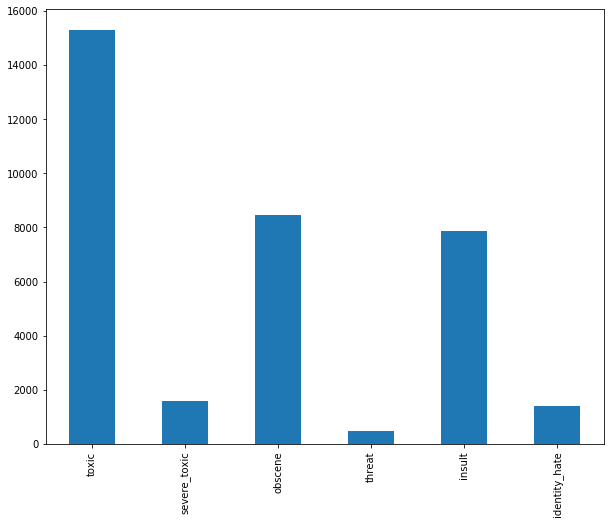

In [66]:
# Plot figure
toxic_comments_labels.sum(axis=0).plot.bar()

There are two ways to create multi-label classification models: Using single dense output layer and using multiple dense output layers.                                                                                                  

        1. In the first approach, we can use a single dense layer with six outputs with a sigmoid activation functions and binary cross entropy loss functions. Each neuron in the output dense layer will represent one of the six output labels. The sigmoid activation function will return a value between 0 and 1 for each neuron. If any neuron's output value is greater than 0.5, it is assumed that the comment belongs to the class represented by that particular neuron.                                                                                                                               2. In the second approach we will create one dense output layer for each label. We will have a total of 6 dense layers in the output. Each layer will have its own sigmoid function.

### Preprocessing Data

In [20]:
# Preprocessing text
def preprocess_text(text):
    #remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', text)
    
    #single character removal
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    
    #remove multiple white spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

### Train Test Split

In [21]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = toxic_comments_labels.values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

### Convert text inputs to Embedded Vectors

In [24]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
# GloVe word embeddings to convert text inputs to their numeric counterparts
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Single output layer structure

In [26]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14832600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,950,622
Trainable params: 118,022
Non-trainable params: 14,832,600
_________________________________________________________________
None


In [30]:
# Network Architecture
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 562s 6ms/step - loss: 0.1266 - accuracy: 0.9662 - val_loss: 0.0669 - val_accuracy: 0.9773
Epoch 2/5
102124/102124 [==============================] - 562s 6ms/step - loss: 0.0622 - accuracy: 0.9790 - val_loss: 0.0582 - val_accuracy: 0.9805
Epoch 3/5
102124/102124 [==============================] - 566s 6ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 0.0562 - val_accuracy: 0.9807
Epoch 4/5
102124/102124 [==============================] - 576s 6ms/step - loss: 0.0538 - accuracy: 0.9811 - val_loss: 0.0544 - val_accuracy: 0.9811
Epoch 5/5
102124/102124 [==============================] - 580s 6ms/step - loss: 0.0522 - accuracy: 0.9815 - val_loss: 0.0539 - val_accuracy: 0.9815


In [32]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 35s 1ms/step
Test Score: 0.053891471526541015
Test Accuracy: 0.9811792373657227


### Multiple output layer structure

In [67]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [68]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [70]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [71]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [72]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [73]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     14832600    input_4[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 128)          117248      embedding_4[0][0]                
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 1)            129         lstm_4[0][0]                     
____________________________________________________________________________________________

In [75]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 210s 2ms/step - loss: 3.1744 - dense_14_loss: 0.5570 - dense_15_loss: 0.4829 - dense_16_loss: 0.5485 - dense_17_loss: 0.4947 - dense_18_loss: 0.5461 - dense_19_loss: 0.4570 - dense_14_accuracy: 0.8981 - dense_15_accuracy: 0.9848 - dense_16_accuracy: 0.9425 - dense_17_accuracy: 0.9882 - dense_18_accuracy: 0.9452 - dense_19_accuracy: 0.9874 - val_loss: 0.9892 - val_dense_14_loss: 0.3225 - val_dense_15_loss: 0.0748 - val_dense_16_loss: 0.2281 - val_dense_17_loss: 0.0801 - val_dense_18_loss: 0.2271 - val_dense_19_loss: 0.0504 - val_dense_14_accuracy: 0.9051 - val_dense_15_accuracy: 0.9896 - val_dense_16_accuracy: 0.9461 - val_dense_17_accuracy: 0.9969 - val_dense_18_accuracy: 0.9505 - val_dense_19_accuracy: 0.9919
Epoch 2/5
102124/102124 [==============================] - 194s 2ms/step - loss: 0.8949 - dense_14_loss: 0.3227 - dense_15_loss: 0.0577 - dense_16_loss: 0.2126 - dense_17

In [76]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 38s 1ms/step
Test Score: 0.8442530509574127
Test Accuracy: 0.31687453389167786


An accuracy of only 31% is achieved on the test set via multiple output layers.

#### Conclusion :

Multi-label text classification is one of the most common text classification problems. In this article, we studied two deep learning approaches for multi-label text classification. In the first approach we used a single dense output layer with multiple neurons where each neuron represented one label.

In the second approach, we created separate dense layers for each label with one neuron. Results show that in our case, single output layer with multiple neurons works better than multiple output layers.